TODO HACKDAVIS DAY 2 (INORDER)
- Normalise the data/Figure out the outliers
  - Boxplots are funky
  - Histograms like the from the lecture (Three colorful shifted histograms)
- Clean up code according to ".h" file in google docs

# Setup


## Import Packages

In [2]:
### KEEP THIS

import csv # lib for reading csvs
import pandas as pd #for processing data into a DataFrame_
import matplotlib.pyplot as plt #for plotting.
%pip install tensorflow
%pip install seaborn
import tensorflow as tf

import seaborn as sns
#dont care about these for now.
import numpy as np #for numerical processing.
from sklearn.linear_model import LogisticRegression #a type of classification model.
from sklearn.model_selection import train_test_split #function useful to split data into (train|test) splits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler #scaling values.
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error, r2_score



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Load Data

In [104]:
### KEEP THIS

# Load the data
solar_data = pd.read_csv("solar_weather_data.csv")

#drop the first 3 columns
solar_data = solar_data.drop(solar_data.columns[0], axis=1)
solar_data = solar_data.drop(solar_data.columns[0], axis=1)
solar_data = solar_data.drop(solar_data.columns[0], axis=1)

# Get collumn names
solar_data_columns = solar_data.columns

# Convert time column from epoch ms to hour in day (ie 16 or 5) with time zone pacific
solar_data['time'] = pd.to_datetime(solar_data['time'], unit='ms')
solar_data['time'] = solar_data['time'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
solar_data['time'] = solar_data['time'].dt.hour

#print(type(solar_data))
pd.set_option('display.width', 1000)
print(solar_data.head(10))
print("\n")

   time  cloudcover   dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation  temp  uvindex  whProduced
0    18        28.1  46.6     71.63     0.0           0          0.2              62           4.9  55.6        1          17
1    19        15.8  45.7     76.61     0.0           0          0.1              14          -6.3  52.8        0           0
2    20         8.7  47.8     85.89     0.0           0          0.1               0         -17.9  51.9        0           0
3    21         8.7  45.9     87.05     0.0           0          0.1               0         -29.8  49.6        0           0
4    22        15.8  46.6     90.75     0.0           0          0.1               0         -41.7  49.2        0           0
5    23        16.5  44.7     85.73     0.0           0          0.1               0         -53.1  48.8        0           0
6     0         8.7  44.7     91.88     0.0           0          0.1               0         -63.2  46.9        0     

In [4]:
### KEEP THIS

## Remove rows which where affected by database outages
# Remove rows where 0 whProduced and sunelevation > -1, the sun cant be up and not producing power
solar_data = solar_data.drop(solar_data[(solar_data['sunelevation'] > -1) & (solar_data['whProduced'] < 5)].index)
# Remove rows with whProduced > 5000, these are likely outliers
solar_data = solar_data.drop(solar_data[solar_data['whProduced'] > 5000].index)

In [10]:
### KEEP THIS

# Drop infinite values and NaN
solar_data = solar_data.replace([np.inf, -np.inf], np.nan)
solar_data = solar_data.dropna()

# Fill NaN values with the mean of the column 
solar_data = solar_data.fillna(solar_data.mean())

## Data Exploration

### Normalize Data

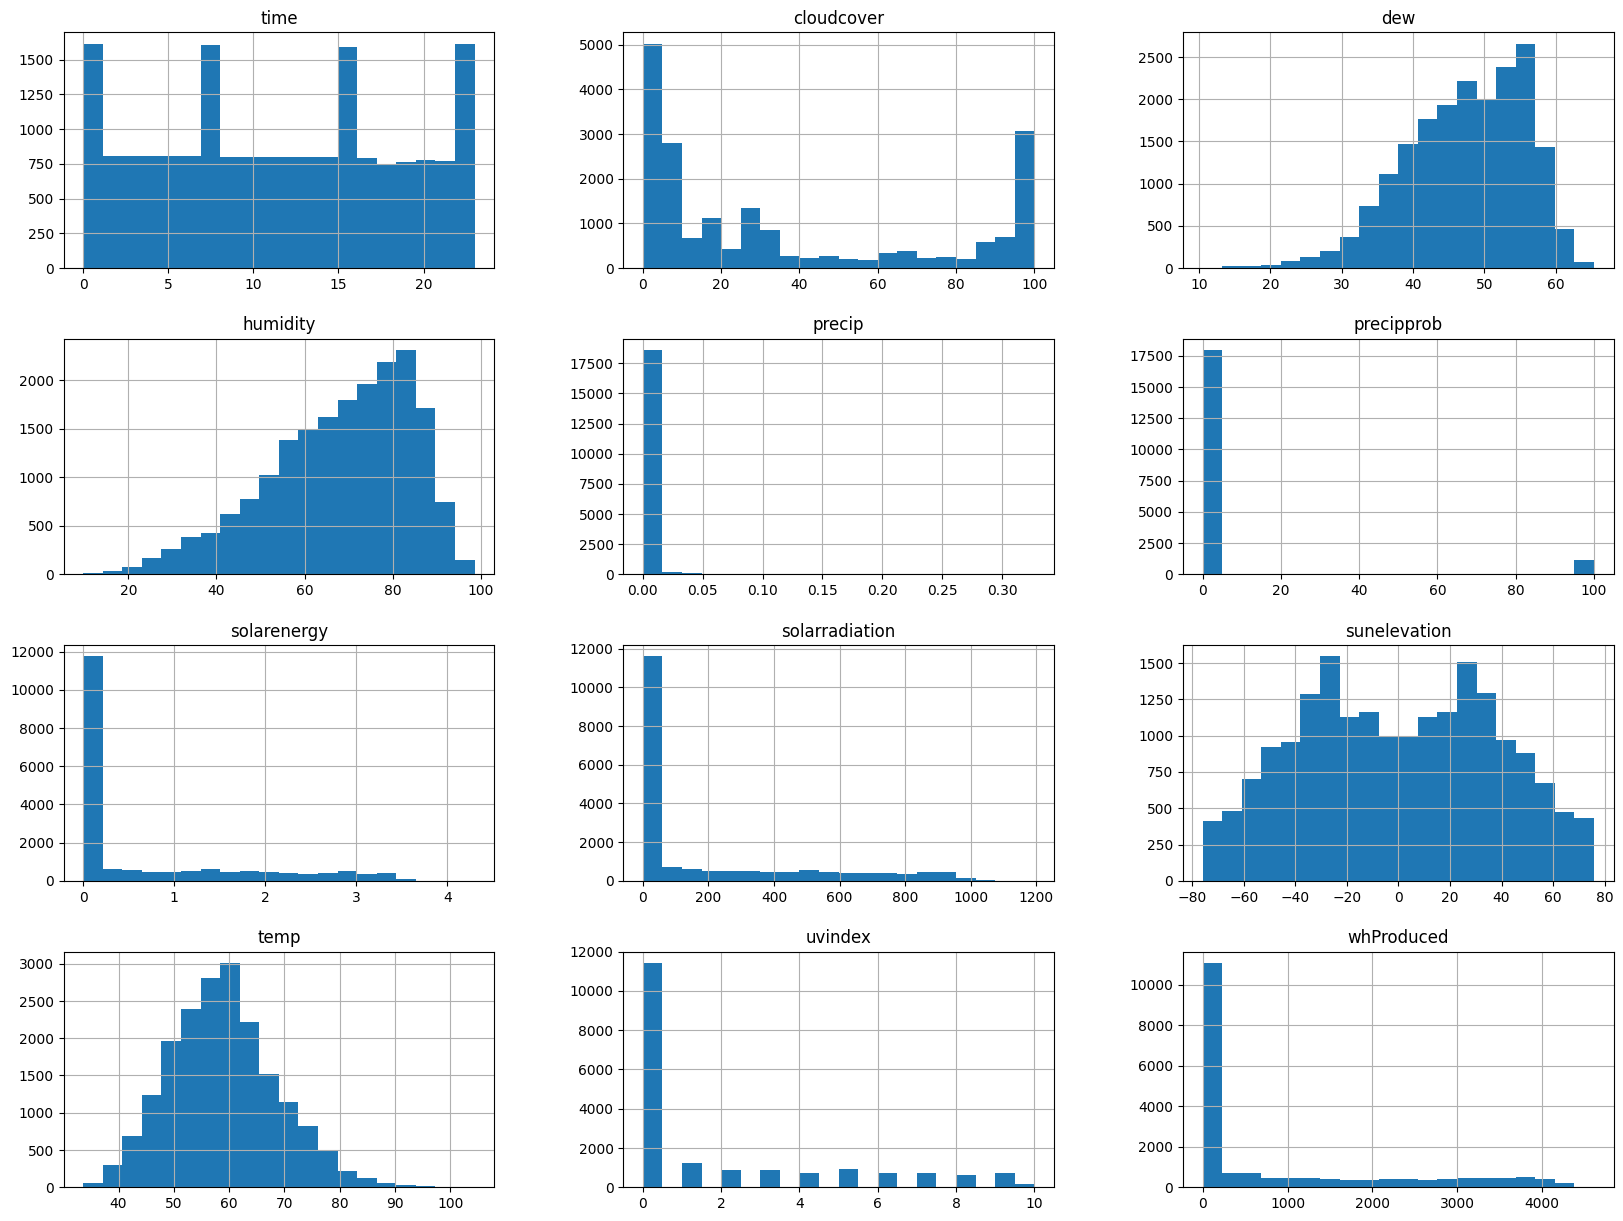

In [6]:
# Plot histograms for each of the features before scaling
solar_data.hist(bins=20, figsize=(20,15))
plt.show()

In [7]:
## REMOVE

#cloudcover	dew	humidity	precip	precipprob	solarenergy	solarradiation	suneleva)tion	temp	uvindex	whproduced

def transform(data):
  data['whProduced'] = np.log(data['whProduced']) #log transform
  data['uvindex'] = np.log(data['uvindex']) #log transform
  data['temp'] = (data['temp'] - data['temp'].mean()) / data['temp'].std() #normalize
  data['sunelevation'] = (data['sunelevation'] - data['sunelevation'].mean()) / data['sunelevation'].std() #normalize
  data['solarradiation'] = np.log(data['solarradiation']) #log transform
  data['solarenergy'] = np.log(data['solarenergy']) #log transform
  data['precipprob'] = np.log(data['precipprob']) #log transform
  data['precip'] = np.log(data['precip']) #log transform
  data['humidity'] = (data['humidity'] - data['humidity'].mean()) / data['humidity'].std() #normalize
  data['dew'] = (data['dew'] - data['dew'].mean()) / data['dew'].std() #normalize
  data['cloudcover'] = (data['cloudcover'] - data['cloudcover'].mean()) / data['cloudcover'].std() #normalize
  return data

solar_data = transform(solar_data)

C:\Users\bledi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
### KEEP THIS

# Normalize with StandardScaler
def normalize_StandardScaler(data):
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(data.drop('whProduced', axis=1))
  # combine the scaled data with the target variable (whProduced)
  data_scaled = pd.DataFrame(data_scaled, columns=solar_data_columns[:-1])
  data_scaled['whProduced'] = data['whProduced']
  return data_scaled


# Normalize with z-score
def normalize_z_score(data):
  # Normalize the input data only
  data_scaled = (data.drop('whProduced', axis=1) - data.drop('whProduced', axis=1).mean()) / data.drop('whProduced', axis=1).std()
  # combine the scaled data with the target variable (whProduced)
  data_scaled['whProduced'] = data['whProduced']
  return data_scaled


# Normalize with min-max
def normalize_min_max(data):
  data_scaled = (data.drop('whProduced', axis=1) - data.drop('whProduced', axis=1).min()) / (data.drop('whProduced', axis=1).max() - data.drop('whProduced', axis=1).min())
  # combine the scaled data with the target variable (whProduced)
  data_scaled['whProduced'] = data['whProduced']
  return data_scaled

          time  cloudcover       dew  humidity    precip  precipprob  solarenergy  solarradiation  sunelevation      temp   uvindex  whProduced
767   0.727273       0.930  0.489510  0.559524  0.000000         NaN     0.227670        0.214148      0.263492  0.468843  0.000000    5.602119
1143  0.090909       0.965  0.391608  0.507806  0.000000         NaN     0.000000        0.000000      0.223810  0.412463  0.000000    6.167516
1148  0.545455       1.000  0.465035  0.573966  0.397515         NaN     0.133179        0.194043      0.712698  0.442136  0.000000    5.932245
1149  0.636364       0.669  0.496503  0.750976  0.797993         NaN     0.133179        0.161282      0.623810  0.376855  0.000000    6.517671
1150  0.727273       0.669  0.538462  0.748048  0.342520         NaN     0.300964        0.343177      0.485714  0.415430  0.000000    6.860664
1152  0.909091       1.000  0.496503  0.678181  0.490326         NaN     0.133179        0.183493      0.139683  0.412463  0.000000    5

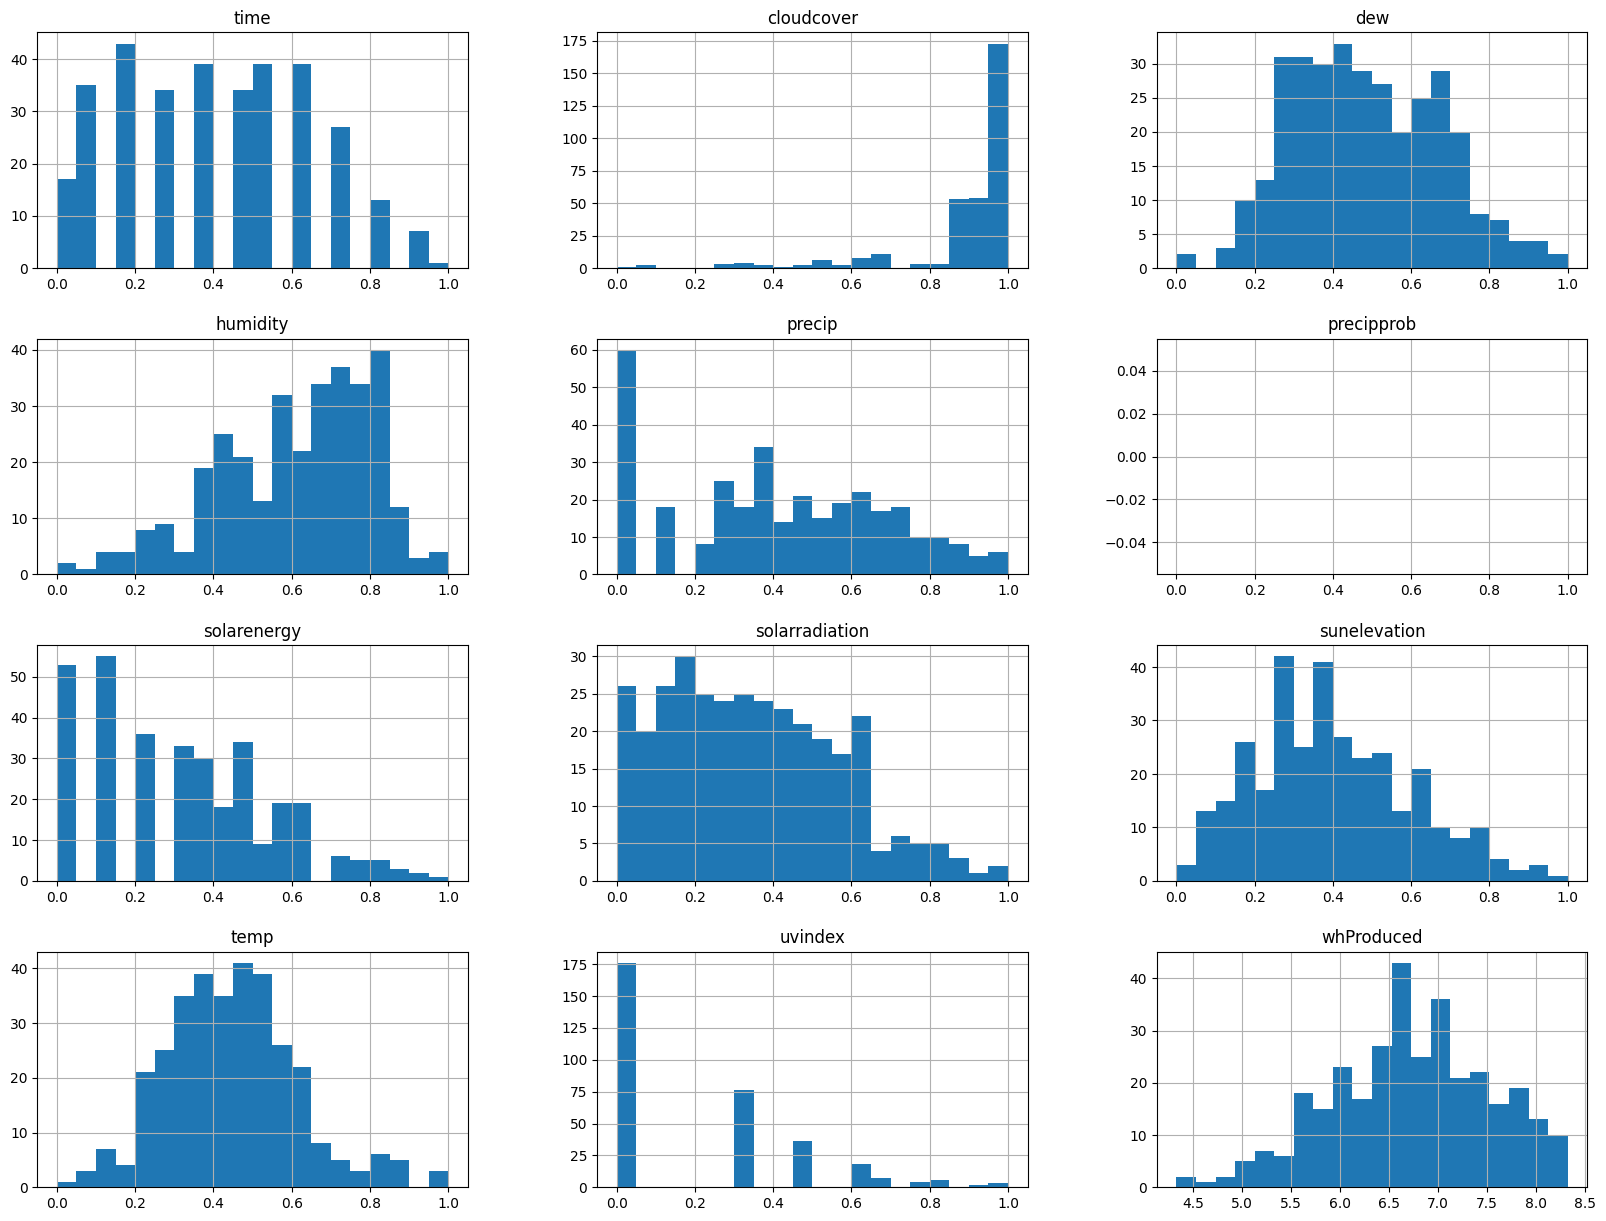

In [14]:
## REMOVE

nomnomtesting = normalize_min_max(solar_data)
print(nomnomtesting.head(20))

nomnomtesting.hist(bins=20, figsize=(20,15))
plt.show()

### Outliers

In [15]:
### KEEP THIS

# Remove rows where whProduced an outlier
def remove_outliers(data):
  Q1 = data['whProduced'].quantile(0.25)
  Q3 = data['whProduced'].quantile(0.75)
  max = Q3 + 1.5 * (Q3 - Q1)
  min = Q1 - 1.5 * (Q3 - Q1)
  # Report number of outliers
  print("Number of outliers: ", data[(data['whProduced'] > max) | (data['whProduced'] < min)].shape[0])
  data = data.drop(data[data['whProduced'] > max].index)
  data = data.drop(data[data['whProduced'] < min].index)
  return data

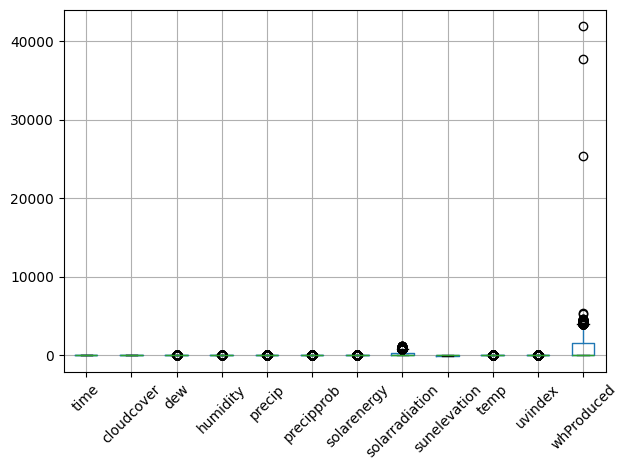

In [105]:
### KEEP THIS

solar_data.boxplot()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Number of outliers:  464


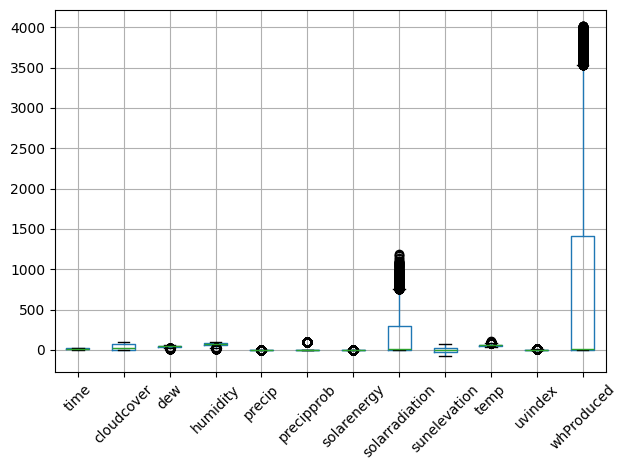

In [106]:
remove_outliers(solar_data).boxplot()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
## REMOVE

def outliers(data):
  # Calculate the first quartile (Q1) and third quartile (Q3)
  Q1 = data.quantile(0.25)
  Q3 = data.quantile(0.75)
  #print(Q1)
  #print(Q3)
  # Calculate the interquartile range (IQR)
  IQR = Q3 - Q1

  # Define a multiplier for the IQR to determine the outlier threshold
  threshold_multiplier = 1.5  # You can adjust this multiplier based on your dataset and requirements

  # Define lower and upper bounds for outlier detection
  lower_bound = Q1 - threshold_multiplier * IQR
  upper_bound = Q3 + threshold_multiplier * IQR

  # Find indices of outliers
  outlier_indices = ((data < lower_bound) | (data > upper_bound)).any(axis=1)

  # Remove outliers from the training set and corresponding target variable
  data = data[~outlier_indices]

  print(outlier_indices)
  # Print the number of outliers removed
  num_outliers_removed = np.sum(outlier_indices)
  print("Number of outliers removed:", num_outliers_removed)

  return data

outliers(solar_data)

0        False
1        False
2        False
3        False
4        False
         ...  
19359    False
19360    False
19361    False
19362     True
19363     True
Length: 19364, dtype: bool
Number of outliers removed: 3070


,time,cloudcover,dew,humidity,precip,precipprob,solarenergy,solarradiation,sunelevation,temp,uvindex,whProduced
0,0.939024,-0.225994,-0.091635,0.228419,-0.141867,-0.252548,-0.481004,-0.453383,0.131160,-0.342714,-0.310611,-0.637610
1,1.083481,-0.551310,-0.199267,0.535764,-0.141867,-0.252548,-0.577733,-0.620179,-0.168563,-0.631817,-0.656263,-0.649860
2,1.227939,-0.739093,0.051874,1.108488,-0.141867,-0.252548,-0.577733,-0.668828,-0.478990,-0.724743,-0.656263,-0.649860
3,1.372396,-0.739093,-0.175349,1.180078,-0.141867,-0.252548,-0.577733,-0.668828,-0.797446,-0.962221,-0.656263,-0.649860
4,1.516853,-0.551310,-0.091635,1.408427,-0.141867,-0.252548,-0.577733,-0.668828,-1.115902,-1.003522,-0.656263,-0.649860
...,...,...,...,...,...,...,...,...,...,...,...,...
19357,-0.505548,-0.969195,-0.127512,1.098613,-0.141867,-0.252548,-0.674462,-0.644504,0.131160,-0.879620,-0.656263,-0.090668
19358,-0.361091,-0.969195,-0.079676,0.611057,-0.141867,-0.252548,-0.190816,-0.213613,0.446940,-0.569867,-0.310611,0.735869
19359,-0.216634,-0.744383,0.135588,0.201881,-0.141867,-0.252548,0.389559,0.370175,0.762720,-0.115561,0.380691,1.419006
19360,-0.072176,-0.744383,0.099711,-0.243091,-0.141867,-0.252548,1.260122,1.259757,1.073147,0.163217,1.417645,1.839120


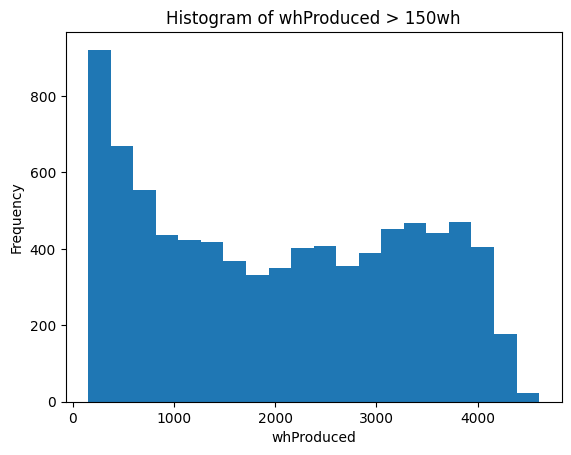

In [ ]:
filtered_data = solar_data[solar_data['whProduced'] > 150]
plt.hist(filtered_data['whProduced'], bins=20)
plt.xlabel('whProduced')
plt.ylabel('Frequency')
plt.title('Histogram of whProduced > 150wh')
plt.show()

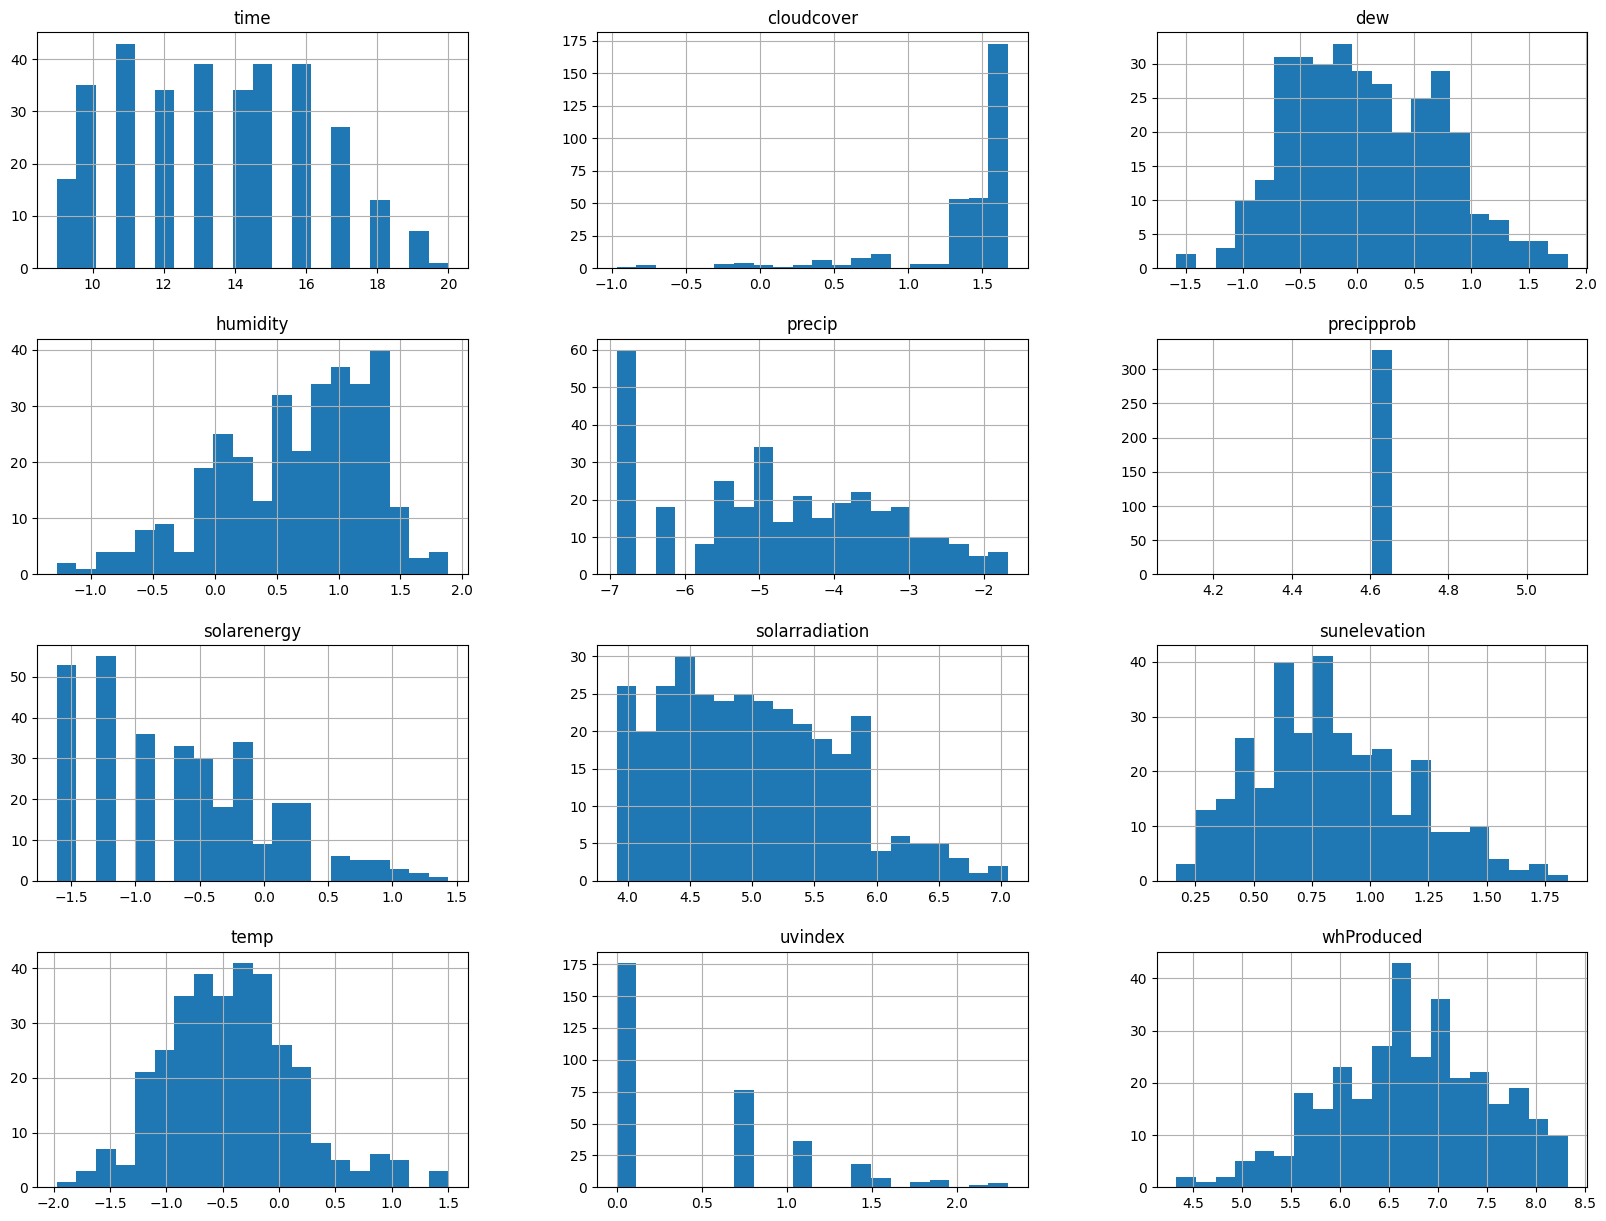

In [18]:
### KEEP THIS

# Plot histograms for each of the features
solar_data.hist(bins=20, figsize=(20,15))
plt.show()

### Correlation

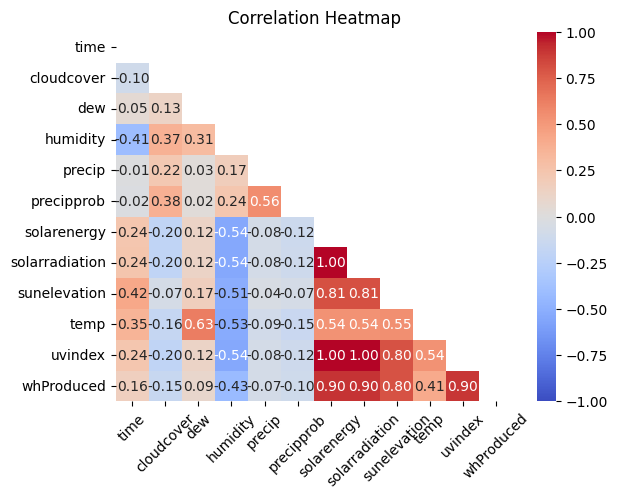

In [ ]:
### KEEP THIS

def correlation_heatmap(data):
  # Calculate the correlation matrix
  corr = data.corr()
  # Create a mask to display only the lower triangle of the matrix (since it's mirrored around its top-left to bottom-right
  mask = np.triu(np.ones_like(corr, dtype=bool))
  # Create the heatmap
  sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.title('Correlation Heatmap')
  plt.show()

correlation_heatmap(solar_data)

In [ ]:
### KEEP THIS

# Drop unwanted columns
def drop_columns(data, columns):
  data = data.drop(columns, axis=1)
  return data

In [ ]:
## REMOVE
def select_ideal_features(df, target_variable, threshold):
    # Compute correlations
    correlations = df.corr()[target_variable].abs().sort_values(ascending=False)
    print(correlations)
    
    # Select features with correlation above the threshold
    selected_features = correlations[correlations > threshold].index.tolist()
    
    # Remove the target variable from selected features
    selected_features.remove(target_variable)
    
    return selected_features

print(select_ideal_features(solar_data, 'whProduced', 0.5))

In [ ]:
## REMOVE

# Remove correlated features
def remove_correlated_features(data, threshold, target_variable):
  # Create correlation matrix
  corr_matrix = data.corr().abs()

  # Find features with correlation above threshold
  correlated_features = set()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if corr_matrix.iloc[i, j] > threshold:
        colname = corr_matrix.columns[i]
        correlated_features.add(colname)

   # Remove target variable from uncorrelated features
  correlated_features.discard(target_variable)

  # Print correlated features being removed
  print("Correlated features being removed: ", correlated_features)
  # Drop correlated features
  data = data.drop(correlated_features, axis=1)

  return data

# Remove highly correlated & uncorrelated features
'''
data: the input data
min: the minimum for uncorrelated features
max: the maximum for correlated features
target_variable: the target variable that we want to predict and should not be removed
'''
def remove_uncorrelated_features(data, min, max, target_variable):
  # Create correlation matrix
  corr_matrix = data.corr().abs()

  # Find features with correlation above threshold
  correlated_features = set()
  uncorrelated_features = set()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if corr_matrix.iloc[i, j] > max:
        colname = corr_matrix.columns[i]
        uncorrelated_features.add(colname)
      elif corr_matrix.iloc[i, j] < min:
        colname = corr_matrix.columns[i]
        uncorrelated_features.add(colname)

  # Remove target variable from uncorrelated features
  uncorrelated_features.discard(target_variable)

  # Print uncorrelated features being removed
  print("Uncorrelated features being removed: ", uncorrelated_features)
  # Drop uncorrelated features
  data = data.drop(uncorrelated_features, axis=1)

  return data


print(remove_uncorrelated_features(solar_data, -0.05, 0.05,'whProduced').head(10))

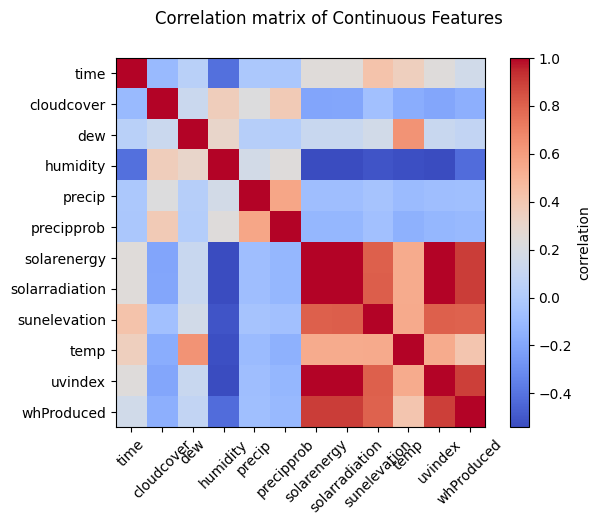

In [ ]:
corrmat = solar_data.corr()
plt.imshow(corrmat, cmap='coolwarm')
plt.colorbar(label = "correlation")
plt.xticks(range(len(corrmat)), corrmat.columns, rotation=45)
plt.yticks(range(len(corrmat)), corrmat.columns)
plt.suptitle("Correlation matrix of Continuous Features")
plt.show()

## Models

### Linear Regression

In [107]:
### KEEP THIS
def polynomial_regression(degree, data, folds, test_size, target_name, random_state=None):
    # Split the data into features and target variable
    X = data.drop(target_name, axis=1).values
    y = data[target_name].values

    # Define number of folds for cross-validation
    kf = KFold(folds)

    # Initialize lists to store results
    variances = []
    biases = []
    total_error = []
    models = []


    # Set the polynomial degree of the model
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)

    # Perform cross-validation
    for train_index, test_index in kf.split(X_poly):
        # Split data into training and testing sets for this fold
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Calculate variance and R^2 for this fold
        variance = np.mean((np.mean(y_pred) - y_pred) ** 2)
        bias2 = np.mean((np.mean(y_pred) - y_test) ** 2)

        # Append results to lists
        variances.append(variance)
        biases.append(bias2)
        total_error.append(bias2 + variance)
        models.append(model)

        # Print results for this fold
        print("Variance: {:.4f}, Bias2: {:.4f}, Total error: {:.4f}".format(variance, bias2, bias2 + variance))

    min_error_index = np.argmin(total_error)
    best_model = models[min_error_index]
    print("Selected model's Total reducible error:{}".format(total_error[min_error_index]))


    # Testing the final model on the test data
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=42)
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    print("Mean Squared Error: {:.4f}".format(mse))
    print("R^2 Score: {:.4f}".format(r2))
    print("Root Mean Squared Error: {:.4f}".format(rmse))
    print("Mean Absolute Error: {:.4f}".format(mae))
    
    return best_model, mse, total_error[min_error_index], y_test, y_pred


# Example usage:
# best_model, mse_scores, total_error, y_test, y_pred = polynomial_regression(degrees, solar_data, folds, test_size=0.25, random_state=None)

Variance: 1647062.2679, Bias2: 2791151.5845, Total error: 4438213.8524
Variance: 1368807.1547, Bias2: 1606272.1112, Total error: 2975079.2659
Variance: 1352469.9928, Bias2: 1920996.7988, Total error: 3273466.7916
Variance: 1820751.9732, Bias2: 2051298.3212, Total error: 3872050.2944
Variance: 935784.0366, Bias2: 1114893.1352, Total error: 2050677.1717
Selected model's Total reducible error:2050677.1717426842
Mean Squared Error: 274704.1842
R^2 Score: 0.8434
Root Mean Squared Error: 524.1223
Mean Absolute Error: 374.0155
Mean Squared Error:  274704.1841881561
Total reducible error:  2050677.1717426842


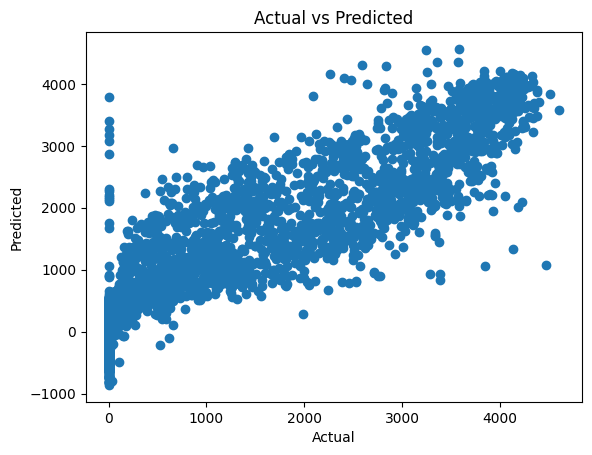

In [130]:
### KEEP THIS
from sklearn.linear_model import LinearRegression

temp_data = normalize_StandardScaler(solar_data)

# call the function
best_model, mse, total_error, y_test, y_pred = polynomial_regression(1, temp_data, 5, 0.25, 'whProduced', None)

print("Mean Squared Error: ", mse)
print("Total reducible error: ", total_error)

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

### KEEP THIS


Epoch: 0, MSE: 733643.6213671666, MAE: 356.5026228052307
Epoch: 1, MSE: 567961.718778177, MAE: 317.3655729094839
Epoch: 2, MSE: 461193.217267493, MAE: 277.4068584915772
Epoch: 3, MSE: 412844.9908832541, MAE: 255.0743201890865
Epoch: 4, MSE: 436109.7226615925, MAE: 268.88676451355525
Epoch: 5, MSE: 409907.60658571223, MAE: 252.85756611254874
Epoch: 6, MSE: 546075.2457646866, MAE: 279.64500797838383
Epoch: 7, MSE: 413238.5334661198, MAE: 249.96945739529693
Epoch: 8, MSE: 413854.35214362317, MAE: 253.07765710810003
Epoch: 9, MSE: 464351.6404979075, MAE: 293.5884399205938
Epoch: 10, MSE: 442614.43327295873, MAE: 272.40464614943824
Epoch: 11, MSE: 409502.05467628204, MAE: 246.49077114094172
Epoch: 12, MSE: 409555.42609427584, MAE: 242.8106965117051
Epoch: 13, MSE: 416126.79192623566, MAE: 251.87249417271366
Epoch: 14, MSE: 411373.24573211494, MAE: 244.9042401544833
Epoch: 15, MSE: 464938.0279497954, MAE: 283.40620610292416
Epoch: 16, MSE: 419135.3581268065, MAE: 243.04027355828512
Epoch: 17

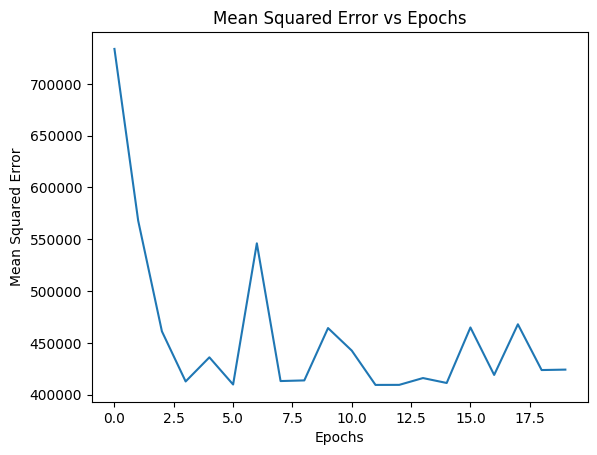

In [151]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Linear Regression Model
class LinearRegression:
    def __init__(self):
        self.theta = None

    def fit(self, X, y, lr=0.01, epochs=20, batch_size=None, verbose=True):
        self.theta = np.random.randn(X.shape[1])
        m = X.shape[0]
        loss_history = []

        for epoch in range(epochs):
            if batch_size:
                num_batches = m // batch_size
            else:
                num_batches = 1
                batch_size = m
            
            # Iterate over the batches in each epoch
            for _ in range(num_batches):
                if batch_size:
                    indices = np.random.choice(m, batch_size, replace=False)
                    X_batch = X[indices]
                    y_batch = y[indices]
                else:
                    X_batch = X
                    y_batch = y

                y_pred = X_batch.dot(self.theta)
                error = y_pred - y_batch

                gradient = 2 * X_batch.T.dot(error) / batch_size
                self.theta -= lr * gradient

            y_train_pred = X.dot(self.theta)
            mse = mean_squared_error(y, y_train_pred)
            loss_history.append(mse)
            mae = np.mean(np.abs(y - y_train_pred))
            if verbose:
                print(f'Epoch: {epoch}, MSE: {mse}, MAE: {mae}')

        return loss_history


def Gradient_descent(input_data, lr=0.01, epochs=20, test_size=0.25, batch_size=None):
    X = input_data.iloc[:, :-1]
    y = input_data.iloc[:, -1]

    y.index = X.index

    poly = PolynomialFeatures(2)
    X_poly = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=test_size, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    model = LinearRegression()
    loss_history = model.fit(X_train_scaled, y_train, lr, epochs, batch_size=batch_size)

    def evaluate_model(model, X_test, y_test):
        y_pred = X_test.dot(model.theta)
        mse = mean_squared_error(y_test, y_pred)
        return mse

    mse = evaluate_model(model, X_test_scaled, y_test)

    return model, mse, loss_history

# Example usage:
# Normalize the data
def normalize_z_score(df):
    return (df - df.mean()) / df.std()

# Assuming solar_data is your dataframe
# Example solar_data definition for illustration
# solar_data = pd.DataFrame(np.random.randn(100, 5), columns=['A', 'B', 'C', 'D', 'Target'])

temp_data = normalize_z_score(solar_data)

temp_data.reset_index(drop=True, inplace=True)

model, mse, loss_history = Gradient_descent(solar_data, lr=0.01, epochs=20, test_size=0.25, batch_size=20)

print("Mean Squared Error: ", mse)

plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Epochs')
plt.show()


In [139]:
### KEEP THIS

# Normalize the data
temp_data = normalize_z_score(solar_data)

# Reset the index
temp_data.reset_index(drop=True, inplace=True)

# Call the Batch Gradient Descent function
model, mse, loss_history = Gradient_descent(temp_data, lr=0.01, epochs=20, test_size=0.25, batch_size=1)

print("Mean Squared Error: ", mse)

# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')

plt.title('Mean Squared Error vs Epochs')
plt.show()

### KEEP THIS

KeyError: "None of [Index([6002], dtype='int32')] are in the [index]"

Epoch 0, MSE: 571811.0304594134
Epoch 10, MSE: 782074.1978793524
Mean Squared Error:  321949.3492054933
Mean Absolute Error:  408.49457328022936
R^2 Score:  0.8164114975426506


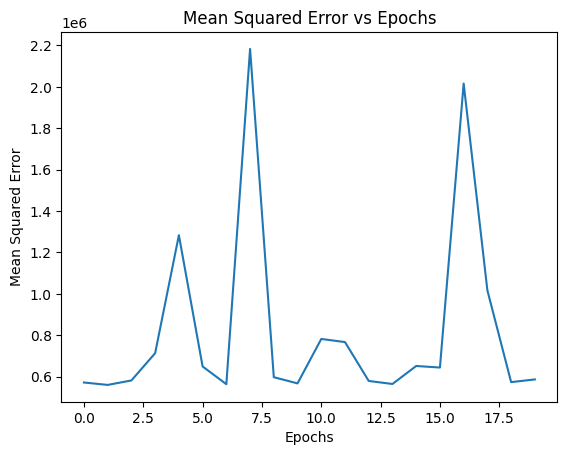

In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

class LinearRegression:
    def __init__(self):
        self.theta = None

    def sgd_fit(self, X, y, lr=0.01, epochs=20, verbose=True):
        self.theta = np.random.randn(X.shape[1])
        m = X.shape[0]
        loss_history = []

        for epoch in range(epochs):
            for i in range(m):
                random_index = np.random.randint(m)
                xi = X[random_index:random_index+1]
                yi = y[random_index:random_index+1]

                y_pred = xi.dot(self.theta)
                error = y_pred - yi
                
                gradient = 2 * xi.T.dot(error)
                self.theta -= lr * gradient
            
            # Calculating loss for the whole dataset at the end of each epoch
            y_train_pred = X.dot(self.theta)
            mse = mean_squared_error(y, y_train_pred)
            loss_history.append(mse)
            if verbose and epoch % 10 == 0:
                print(f'Epoch {epoch}, MSE: {mse}')
        
        return loss_history

def Gradient_descent(input_data, lr=0.01, epochs=20, test_size=0.20, normalize_method='z-score'):
    X = input_data.iloc[:, :-1]
    y = input_data.iloc[:, -1]

    # Ensure X and y have the same index
    y.index = X.index

    # Splitting the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Normalizing the attributes of the Dataset
    if normalize_method == 'standard':
        scaler = StandardScaler()
    elif normalize_method == 'z-score':
        scaler = StandardScaler()
    elif normalize_method == 'min-max':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Unsupported normalization method")

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add the column of 1 values to X for the intercept term
    X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

    # Create an instance of the LinearRegression class
    model = LinearRegression()
    # Fit the model on the training set using SGD
    loss_history = model.sgd_fit(X_train_scaled, y_train, lr, epochs)
    
    # Model Evaluation
    y_test_pred = X_test_scaled.dot(model.theta)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    return model, mse, mae, r2, loss_history

# Example Usage
# Normalize the data
# Assuming `solar_data` is your DataFrame
temp_data = normalize_z_score(solar_data)

# Reset the index
temp_data.reset_index(drop=True, inplace=True)

# Call the Gradient Descent function with SGD
model, mse, mae, r2, loss_history = Gradient_descent(temp_data, lr=0.01, epochs=20, test_size=0.25, normalize_method='z-score')

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("R^2 Score: ", r2)

# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error vs Epochs')
plt.show()


In [92]:
data, lr=0.01, epochs=20):
    X = data.data
    y = housing_data.target
    print("dataset size:{}".format(X.shape[0]))

    # Spliting the dataset into train and test sets [80:20]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Stansdardizing the attributes of the Dataset
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add the column of 1 values to X
    X_train_scaled = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
    X_test_scaled = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
    theta = np.random.randn(X.shape[1])
    m = X.shape[0]
    loss_history = []

    for epoch in range(epochs):
        y_pred = X.dot(theta)
        error = y_pred - y
        gradient = 2 * X.T.dot(error) / m
        theta -= lr * gradient

        mse = mean_squared_error(y, y_pred)
        loss_history.append(mse)

    return theta, loss_history

SyntaxError: unmatched ')' (165273244.py, line 1)

MSE: 261796.18730092872
R^2: 0.8485812347524049


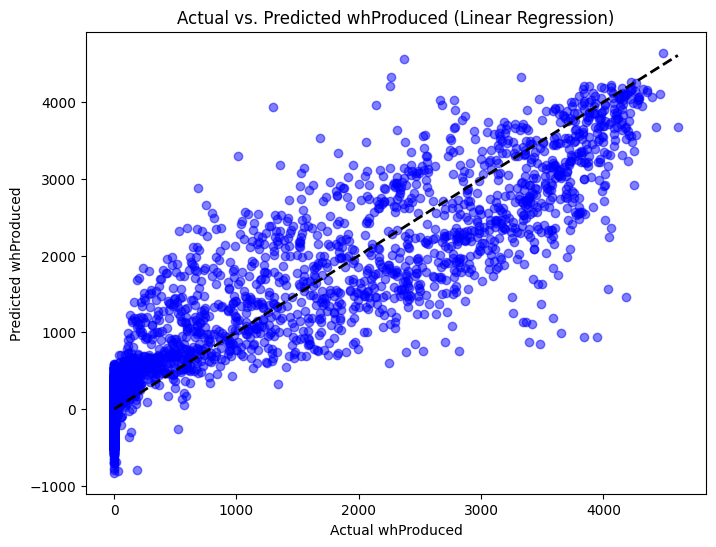

Bias: 1.6122456077304006
Variance: 1482256.664808898


In [ ]:
## OLD CODE
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R^2:", r2)

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Linear Regression)')
plt.show()

mean_predicted = np.mean(y_pred)
mean_true = np.mean(y_test)

# Bias
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2) # 1.6122456077304006
# bias = mean_squared_error(y_test, y_pred)

# Variance
variance = np.var(y_pred)
# variance = np.mean((np.mean(y_test) - y_test) ** 2) # 1728954.7096282812

print("Bias:", bias)
print("Variance:", variance)



In [ ]:
# predict on a row
print(model.predict(X_test.iloc[[16]]))

[-403.51828743]


### Polynomial Regression

Mean Squared Error: 106869062.61091073
R-squared: -60.81137193228572


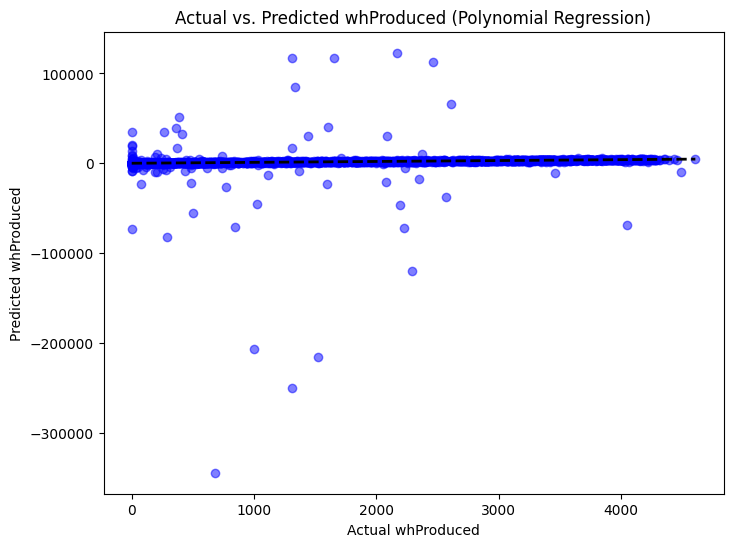

Bias: 1.6122456077304006
Variance: 108282099.45413786


In [ ]:
degree = 5  # Define the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize and train the polynomial regression model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_poly)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Polynomial Regression)')
plt.show()
# bias = np.mean((mean_predicted - y_test) ** 2)
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2)

# Variance
# variance = np.mean((y_pred - mean_predicted) ** 2)
variance = np.var(y_pred)
print("Bias:", bias)
print("Variance:", variance)

Mean Squared Error: 17049484.352634113
R-squared: -8.861151514084305


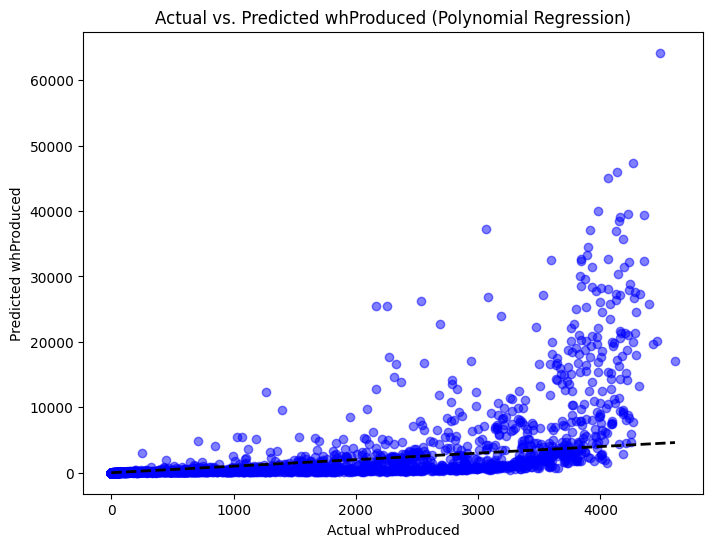

Bias: 1.6122456077304006
Variance: 22467597.87311977


In [ ]:
degree = 2  # Define the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Initialize and train the polynomial regression model
#model = LinearRegression()
#model.fit(X_train_poly, y_train)

# Make predictions on the testing set
#y_pred = model.predict(X_test_poly)

# Transform the target variable
y_train_transformed = np.log1p(y_train)

# Train the model on the transformed data
model.fit(X_train, y_train_transformed)

# Predict the transformed values
y_pred_transformed = model.predict(X_test)

# Apply the inverse transformation to get the final predictions
y_pred = np.expm1(y_pred_transformed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Polynomial Regression)')
plt.show()

# Bias
#bias = np.mean((mean_predicted - y_test) ** 2)
bias = np.mean((np.mean(y_test) - mean_predicted) ** 2)
print("Bias:", bias)

# Variance
#variance = np.mean((y_pred - mean_predicted) ** 2)
variance = np.var(y_pred)
print("Variance:", variance)

In [ ]:
# predict on a row
# print(model.predict(X_train_poly[[18]]))
# print(model.predict(solar_data.iloc[[16]].drop(columns=['whProduced'])))

### Deep Neural Network

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

'''
This function makes a DNN model
'''
class RMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['rmse'] = np.sqrt(logs['loss'])
        if 'val_loss' in logs:
            logs['val_rmse'] = np.sqrt(logs['val_loss'])

def DNN(data, target_variable, test_size, hidden_layers, loss_func, random_state=None, epochs=100, batch_size=32):
  # Split the data into features and target variable
  X = data.drop(target_variable, axis=1).values
  y = data[target_variable].values

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Get the number of input features
  input_shape = X_train.shape[1]
  # Initialize the model
  model = Sequential()
  model.add(Dense(input_shape, input_dim=input_shape, activation='relu'))
  for layer in hidden_layers:
    if layer[1] == 'dropout':
      model.add(Dropout(layer[0]))
    else:
      model.add(Dense(layer[0], activation=layer[1]))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss=loss_func)

  # Print the model summary
  model.summary()

  # Train the model
  rmse_callback = RMSECallback()
  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=test_size, callbacks=[rmse_callback])

  # Plot the training and validation loss
  plt.figure(figsize=(10, 5))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.legend()
  plt.show()
  # Evaluate the model
  mse = model.evaluate(X_test, y_test)
  r2 = r2_score(y_test, model.predict(X_test))

  bias2 = np.mean((np.mean(model.predict(X_test)) - model.predict(X_test)) ** 2)
  variance = np.var(model.predict(X_test))
  total_error = (bias2 + variance)

  y_pred = model.predict(X_test)

  # Print the mean absolute error
  print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

  return model, mse, r2, total_error, y_test, y_pred

def DNN_dataSplit(data, target_variable, test_size, random_state=None):
  # Split the data into features and target variable
  X = data.drop(target_variable, axis=1).values
  y = data[target_variable].values

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  return X_train, X_test, y_train, y_test

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 11)                132       
                                                                 
 dense_98 (Dense)            (None, 2048)              24576     
                                                                 
 dense_99 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_100 (Dense)           (None, 512)               524800    
                                                                 
 dense_101 (Dense)           (None, 256)               131328    
                                                                 
 dense_102 (Dense)           (None, 128)               32896     
                                                                 
 dense_103 (Dense)           (None, 64)               

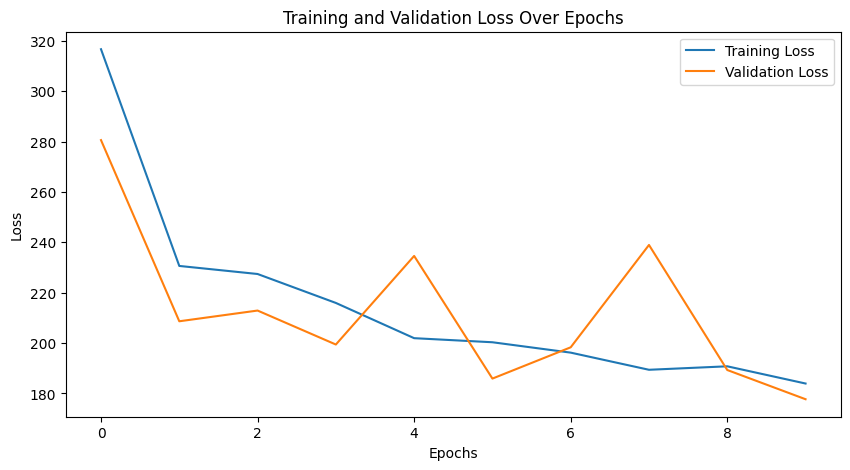

150/150 [==============================] - 0s 2ms/step
Mean Absolute Error: 167.2485567599089


167.2485567599089

In [ ]:
# Run the DNN function
hidden_layers = [
  [2048, 'sigmoid'],
  [1024, 'relu'],
  [512, 'relu'],
  [256, 'relu'],
  [128, 'relu'],
  [64, 'relu'],
  [32, 'relu'],
  [16, 'relu']
]

model, mse, r2, total_error, y_test, y_pred = DNN(solar_data, 'whProduced', 0.25, hidden_layers, 'mae', None, 10, 32)

mean_absolute_error(y_test, y_pred)

In [ ]:
# Predict on a row
testRow = 18020
print(solar_data.iloc[[testRow]])
# Get the actual values
actual = solar_data.iloc[[testRow]]['whProduced'].values[0]
print("Actual: ", actual)
predicted = model.predict(solar_data.iloc[[testRow]].drop(columns=['whProduced']))[0][0]
print("Predicted: ", predicted)
diffrence = abs(actual - predicted)
print("Difference: ", diffrence)
if actual > 0:
  print("Percent Error: ", (abs((predicted - actual)/actual) * 100))

       time  cloudcover   dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation  temp  uvindex  whProduced
18270     0        92.6  44.8     71.83   0.004         100          0.0               0         -54.6  53.7        0           0
Actual:  0
1/1 [==============================] - 0s 13ms/step
Predicted:  0.0009371191
Difference:  0.0009371191263198853


In [ ]:
# Average the percent error for the entire dataset
percent_error = []
# Loop through the dataset and calculate the percent error for each row with an upper bound of 1000
for i in range(len(solar_data)):
  actual = solar_data.iloc[[i]]['whProduced'].values[0]
  predicted = model.predict(solar_data.iloc[[i]].drop(columns=['whProduced']))[0][0]
  diffrence = abs(actual - predicted)
  if actual > 0:
    percent_error.append(abs((predicted - actual)/actual) * 100)

print("Average Percent Error: ", sum(percent_error) / len(percent_error))

1/1 [==============================] - 0s 13ms/step
Average Percent Error:  31.64127717643933


In [ ]:
print(percent_error)

[759.6454395967371, 293.523391412229, 1.3958153504408553, 7.2207564546021725, 38.33998937252739, 32.54301729258041, 105.38822194044504, 118.59817904327552, 17.06823569614751, 11.668325570913462, 10.528662545340401, 472.04384436974163, 51.51970460242832, 1.6219182600054824, 9.932272518382353, 4.45416788569105, 2.8038087658820503, 4.106920180277076, 16.14103408784189, 150.91138872351283, 250.96555813192737, 96.53006962367466, 104.53792572021486, 22.180213928222656, 22.086138866661052, 13.906614588423574, 0.5543451010709769, 2.495071527067504, 0.44324560072815533, 19.113690480554904, 177.36429723893633, 311.5445166519008, 92.77753829956055, 140.86957659040178, 38.0861185364804, 27.83630151542828, 19.291828840206833, 9.62728683297703, 18.49811036089866, 8.969109542857794, 25.0329494724026, 58.91574171112804, 127.16266118992141, 8.85571837425232, 314.131768544515]


Epoch 1/100
383/383 [==============================] - 0s 678us/step - loss: 929939.0625 - val_loss: 234824.6094
Epoch 2/100
383/383 [==============================] - 0s 578us/step - loss: 183082.5312 - val_loss: 148487.7969
Epoch 3/100
383/383 [==============================] - 0s 577us/step - loss: 126463.9766 - val_loss: 112123.1016
Epoch 4/100
383/383 [==============================] - 0s 586us/step - loss: 105045.9375 - val_loss: 99578.0156
Epoch 5/100
383/383 [==============================] - 0s 578us/step - loss: 98244.5938 - val_loss: 97045.8047
Epoch 6/100
383/383 [==============================] - 0s 596us/step - loss: 95366.7031 - val_loss: 94184.3438
Epoch 7/100
383/383 [==============================] - 0s 584us/step - loss: 93019.7812 - val_loss: 90869.1250
Epoch 8/100
383/383 [==============================] - 0s 589us/step - loss: 91336.2891 - val_loss: 90535.5234
Epoch 9/100
383/383 [==============================] - 0s 568us/step - loss: 90880.7891 - val_loss: 93338

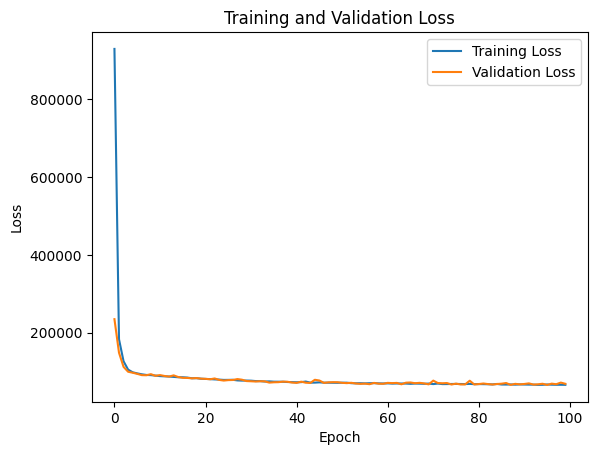

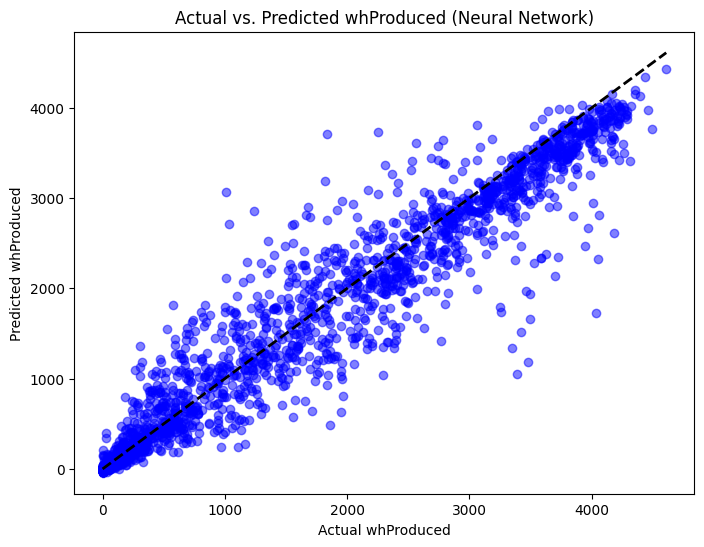

Bias: 1728956.3218738888
Variance: 1553609.2


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual whProduced')
plt.ylabel('Predicted whProduced')
plt.title('Actual vs. Predicted whProduced (Neural Network)')
plt.show()

bias = np.mean((mean_predicted - y_test) ** 2)

# Variance
variance = np.mean((y_pred - mean_predicted) ** 2)
print("Bias:", bias)
print("Variance:", variance)

# Transformation of skewed data

import numpy as np
import matplotlib.pyplot as plt

skewed_data=y


/Users/christopher/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/christopher/miniconda3/envs/tf/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 8.435766192720509] is not finite

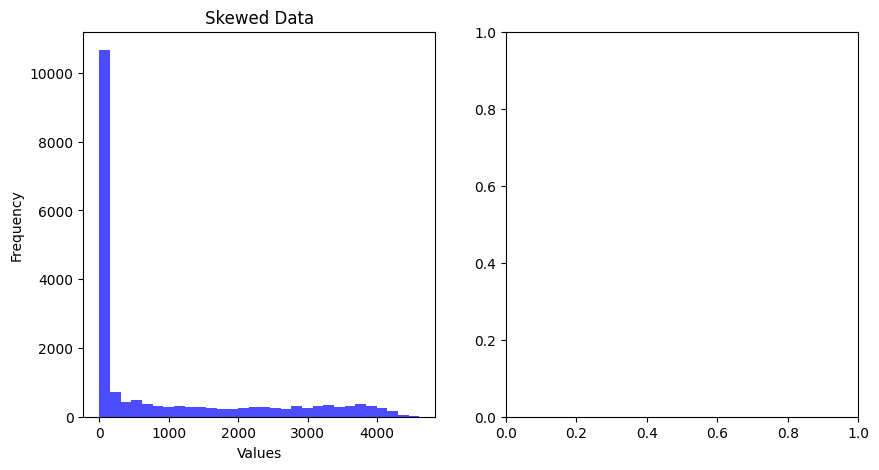

In [ ]:
# Plot the histogram of skewed data
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(skewed_data, bins=30, color='blue', alpha=0.7)
plt.title('Skewed Data')
plt.xlabel('Values')
plt.ylabel('Frequency')

# Apply transformations
log_transformed = np.log(skewed_data)
sqrt_transformed = np.sqrt(skewed_data)
inverse_transformed = 1 / skewed_data
exp_transformed = np.exp(skewed_data)

# Plot histograms of transformed data
plt.subplot(1, 2, 2)
plt.hist(log_transformed, bins=30, color='green', alpha=0.7, label='Log Transformation')
plt.hist(sqrt_transformed, bins=30, color='red', alpha=0.7, label='Square Root Transformation')
plt.hist(inverse_transformed, bins=30, color='purple', alpha=0.7, label='Inverse Transformation')
plt.hist(exp_transformed, bins=30, color='purple', alpha=0.7, label='Inverse Transformation')

plt.title('Transformed Data')
plt.xlabel('Transformed Values')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

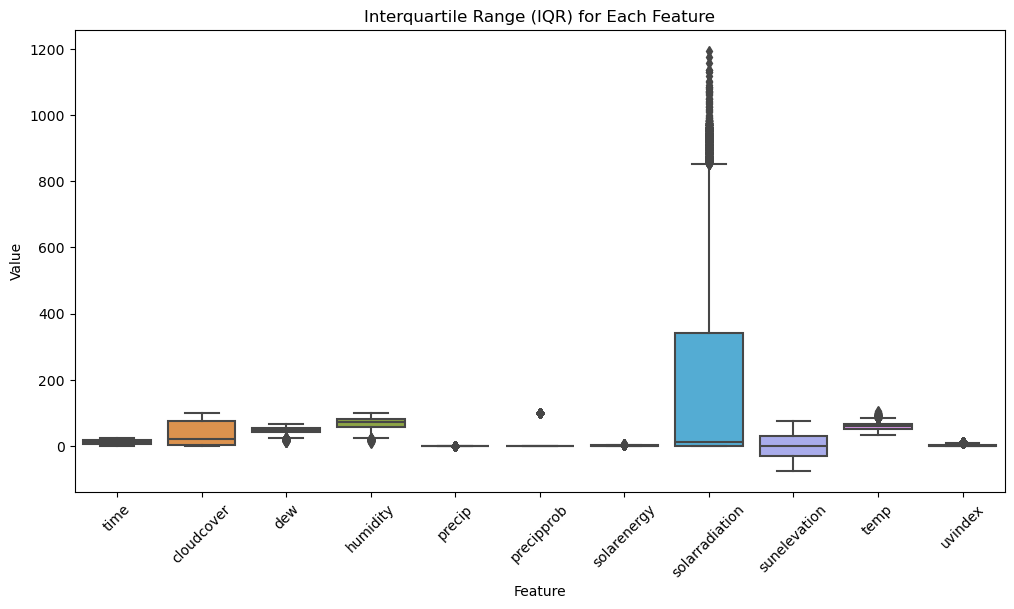

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.title('Interquartile Range (IQR) for Each Feature')
plt.ylabel('Value')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

# Experiments

## DNN Experiments

### Massive Network

In [ ]:
# Run the DNN function
hidden_layers = [
  [2048, 'sigmoid'],
  [0.2, 'dropout'],
  [2048, 'sigmoid'],
  [1024, 'relu'],
  [512, 'relu'],
  [256, 'relu'],
  [128, 'relu'],
  [64, 'relu'],
  [32, 'relu'],
  [16, 'relu']
]

massivenet = 0

massivenet.model, massivenet.mse, massivenet.r2, massivenet.total_error, massivenet.y_test, massivenet.y_pred = DNN(solar_data, 'whProduced', 0.25, hidden_layers, 'mae', None, 100, 32)

massivenet.mae = mean_absolute_error(y_test, y_pred)
print("MAE = ", massivenet.mae)
# MAE = 

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 11)                132       
                                                                 
 dense_148 (Dense)           (None, 2048)              24576     
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_149 (Dense)           (None, 2048)              4196352   
                                                                 
 dense_150 (Dense)           (None, 1024)              2098176   
                                                                 
 dense_151 (Dense)           (None, 512)               524800    
                                                                 
 dense_152 (Dense)           (None, 256)             

KeyboardInterrupt: 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 11)                132       
                                                                 
 dense_130 (Dense)           (None, 2048)              24576     
                                                                 
 dense_131 (Dense)           (None, 1024)              2098176   
                                                                 
 dense_132 (Dense)           (None, 512)               524800    
                                                                 
 dense_133 (Dense)           (None, 256)               131328    
                                                                 
 dense_134 (Dense)           (None, 128)               32896     
                                                                 
 dense_135 (Dense)           (None, 64)              

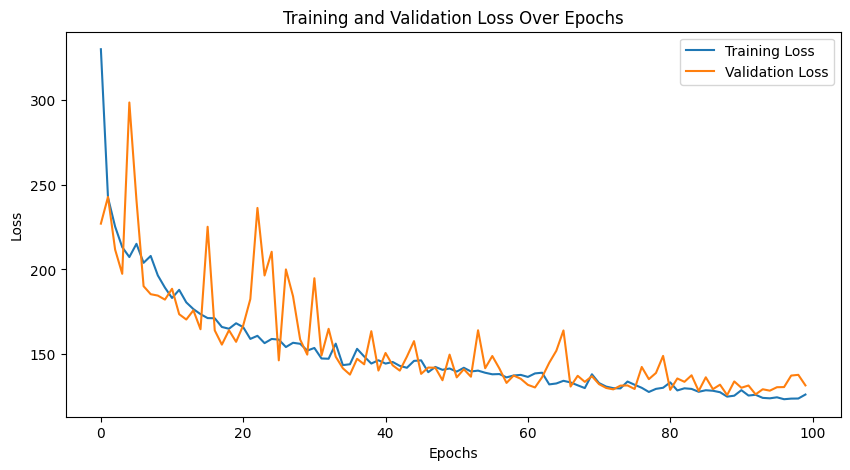

150/150 [==============================] - 0s 2ms/step
Mean Absolute Error: 136.58480212958514
MAE =  136.58480212958514


In [ ]:
# Run the DNN function
hidden_layers = [
  [2048, 'sigmoid'],
  [1024, 'relu'],
  [512, 'relu'],
  [256, 'relu'],
  [128, 'relu'],
  [64, 'relu'],
  [32, 'relu'],
  [16, 'relu']
]

largenet = 0

largenet.model, largenet.mse, largenet.r2, largenet.total_error, largenet.y_test, largenet.y_pred = DNN(solar_data, 'whProduced', 0.25, hidden_layers, 'mae', None, 100, 32)

largenet.mae = mean_absolute_error(y_test, y_pred)
print("MAE = ", largenet.mae)
# MAE = 

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_166 (Dense)           (None, 11)                132       
                                                                 
 dense_167 (Dense)           (None, 512)               6144      
                                                                 
 dense_168 (Dense)           (None, 256)               131328    
                                                                 
 dense_169 (Dense)           (None, 128)               32896     
                                                                 
 dense_170 (Dense)           (None, 64)                8256      
                                                                 
 dense_171 (Dense)           (None, 32)                2080      
                                                                 
 dense_172 (Dense)           (None, 16)              

Epoch 1/10
336/336 [==============================] - 1s 2ms/step - loss: 342.6320 - val_loss: 310.5686 - rmse: 18.5103 - val_rmse: 17.6230
Epoch 2/10
336/336 [==============================] - 1s 2ms/step - loss: 289.0988 - val_loss: 339.7255 - rmse: 17.0029 - val_rmse: 18.4316
Epoch 3/10
336/336 [==============================] - 1s 2ms/step - loss: 263.5817 - val_loss: 242.6836 - rmse: 16.2352 - val_rmse: 15.5783
Epoch 4/10
336/336 [==============================] - 1s 2ms/step - loss: 232.0799 - val_loss: 219.6705 - rmse: 15.2342 - val_rmse: 14.8213
Epoch 5/10
336/336 [==============================] - 1s 2ms/step - loss: 222.4046 - val_loss: 210.7838 - rmse: 14.9132 - val_rmse: 14.5184
Epoch 6/10
336/336 [==============================] - 1s 2ms/step - loss: 214.4777 - val_loss: 232.2827 - rmse: 14.6451 - val_rmse: 15.2408
Epoch 7/10
336/336 [==============================] - 1s 2ms/step - loss: 210.7614 - val_loss: 206.6251 - rmse: 14.5176 - val_rmse: 14.3745
Epoch 8/10
336/336 [

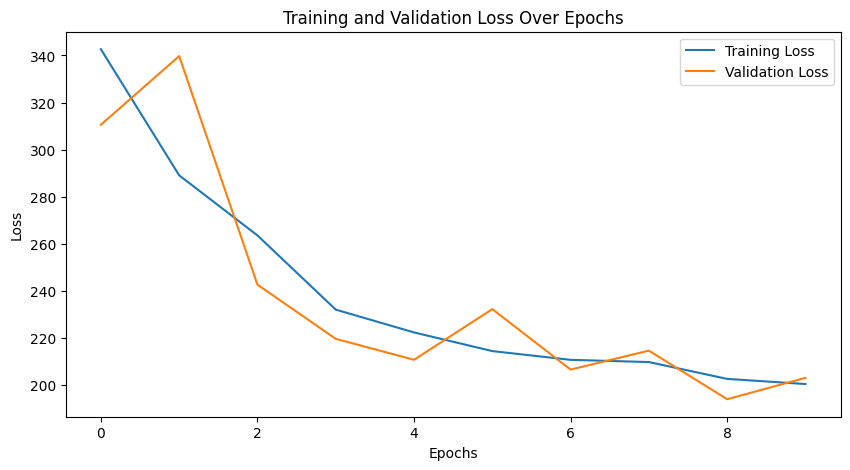

150/150 [==============================] - 0s 592us/step
Mean Absolute Error: 190.48026010116337
MAE =  136.58480212958514


In [ ]:
# Run the DNN function
hidden_layers = [
  [512, 'relu'],
  [256, 'relu'],
  [128, 'relu'],
  [64, 'relu'],
  [32, 'relu'],
  [16, 'relu']
]

mediumnet_model, mediumnet_mse, mediumnet_r2, mediumnet_total_error, mediumnet_y_test, mediumnet_y_pred = DNN(solar_data, 'whProduced', 0.25, hidden_layers, 'mae', None, 10, 32)

mediumnet_mae = mean_absolute_error(y_test, y_pred)
print("MAE = ", mediumnet_mae)
# MAE = 

In [ ]:
# Export the model
mediumnet_model.save('mediumnet_model.h5')

/Users/christopher/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Import the model
loaded_model = tf.keras.models.load_model('mediumnet_model.h5')

# Predict on a row
testRow = 18010
print(solar_data.iloc[[testRow]])
# Get the actual values
actual = solar_data.iloc[[testRow]]['whProduced'].values[0]
print("Actual: ", actual)
predicted = loaded_model.predict(solar_data.iloc[[testRow]].drop(columns=['whProduced']))[0][0]
print("Predicted: ", predicted)

       time  cloudcover   dew  humidity  precip  precipprob  solarenergy  solarradiation  sunelevation  temp  uvindex  whProduced
18259    13       100.0  44.8     58.34     0.0           0          2.7             752          45.3  59.4        8        3185
Actual:  3185
1/1 [==============================] - 0s 40ms/step
Predicted:  3200.354
